## Clutch Hitting
Import the data and Define some functions

In [1]:
#Import libraries and s
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Column reference:
# https://baseballsavant.mlb.com/csv-docs

#Import Data
#Read in the Statcast Data - note this is around 4GB of data!
stat_15 = pd.read_csv('../01_Data/statcast_15.zip', parse_dates=['game_date'])
stat_16 = pd.read_csv('../01_Data/statcast_16.zip', parse_dates=['game_date'])
stat_17 = pd.read_csv('../01_Data/statcast_17.zip', parse_dates=['game_date'])
stat_18 = pd.read_csv('../01_Data/statcast_18.zip', parse_dates=['game_date'])
stat_19 = pd.read_csv('../01_Data/statcast_19.zip', parse_dates=['game_date'])
stat_20 = pd.read_csv('../01_Data/statcast_20.zip', parse_dates=['game_date'])

#Combine the data into a single dataframe
stat_years_combined_list = [
    stat_15, 
    stat_16, 
    stat_17, 
    stat_18, 
    stat_19,
    stat_20
]

stat_years_combined_df = pd.concat(
    stat_years_combined_list, 
    ignore_index=True
)

#Split out years
stat_years_combined_df['year'] = stat_years_combined_df[
    'game_date'
].apply(lambda x: x.strftime('%Y'))

#Subset for what I need
stat_comb = stat_years_combined_df[
    ['index', 
     'game_date',
     'year',
     'batter',
     'pitcher',
     'player_name',
     'events',
     'game_type',
     'home_team',
     'away_team',
     'home_score',
     'away_score',
     'bat_score',
     'fld_score',
     'on_1b',
     'on_2b',
     'on_3b',
     'post_home_score',
     'post_away_score',
     'inning',
     'hit_distance_sc',
     'launch_speed',
     'launch_angle',
     'launch_speed_angle',
     'effective_speed',
     'release_speed',
     'release_spin_rate',
     'estimated_ba_using_speedangle',
     'estimated_woba_using_speedangle',
     'pitch_name'
    ]
]

#add_player names
names = pd.read_csv('../01_Data/name_master.csv', encoding = "utf-8")
#names.columns

print('Data imported successfully.\nFormatting and cleaning data...')

#Get we want regular season games:
stat_comb = stat_comb[stat_comb.game_type == 'R']

#Convert NaN to zero for the on-base colums=ns
values = {'on_1b':0,'on_2b':0,'on_3b':0}
stat_comb.fillna(value=values, inplace=True)

#Replace the playerID with an integer for the 1,2 and 3b colums:
stat_comb['on_1b'] = stat_comb['on_1b'].where(stat_comb['on_1b'] == 0, 1)
stat_comb['on_2b'] = stat_comb['on_2b'].where(stat_comb['on_2b'] == 0, 1)
stat_comb['on_3b'] = stat_comb['on_3b'].where(stat_comb['on_3b'] == 0, 1)

#stat_comb[['on_1b','on_2b','on_3b']].head(20)
print('Done!')

Data imported successfully.
Formatting and cleaning data...
Done!


Define workbook functions here

In [2]:
#Functions
from pybaseball import playerid_lookup

def is_clutch(df):
    '''A function which returns whether the event was in a clutch situation. 
    Takes a dataframe as input, returns boolean.
    Uses the statcasat dataset and requires the columns:
        'bat_score' -> int
        'fld_score' -> int
        'inning' -> int
        'on_1b' -> 1 or 0
        'on_2b' -> 1 or 0
        'on_3b' -> 1 or 0
    Note the is_clutch is defined as seen from the perspective of the batter. 
    '''
    if df['inning'] >= 7: #are we in the 7th inning or later, or 6th if we are in 2020?
        score_diff = df['bat_score'] - df['fld_score']
        if ((score_diff == 1) | (score_diff == 0)): #Are they tying, or leading by one point?
            return True
        elif score_diff < 0: #Are they trailing?
            #is the tying run 'on hand'?
            base_status = df['on_1b'] + df['on_2b'] + df['on_3b']#possible runs from bases. 
            if base_status + 2 + score_diff >= 0: 
                return True
            else:
                return False
        else:
            return False
    else:
        return False

## Sanity Checks

In [3]:
#Sanity checks:

stat_comb[['on_1b','on_2b','on_3b']].agg(['unique', 'count'])
stat_comb.launch_speed_angle.agg(['unique','count'])
stat_comb[['on_1b','on_2b','on_3b']].value_counts()
len(stat_comb[stat_comb['on_1b']==0]) + len(stat_comb[stat_comb['on_1b']==1])
len(stat_comb[stat_comb['on_2b']==0]) + len(stat_comb[stat_comb['on_2b']==1])
len(stat_comb[stat_comb['on_3b']==0]) + len(stat_comb[stat_comb['on_3b']==1])


#Explore the data
#stat_years_combined_df.info()
#stat_comb.info()
#stat_comb.columns.sort_values().values

3856615

## Analysis

Let's create two datasets, one during the clutch situations and one not during the clutch situations. 

In [4]:
#Write an extra column to determine whether the row event 
#was a clutch event
stat_comb['clutch'] = stat_comb.apply(is_clutch, axis=1)
stat_comb['clutch'].value_counts()

#Create the data frame with and without clutch events
clutch_df = stat_comb[stat_comb['clutch'] == True]
not_clutch_df = stat_comb[stat_comb['clutch'] == False]

#Sanity checks if required:
#clutch_df[['inning','year']].value_counts()
#clutch_df.columns

Launch Speed Angle

In [5]:
## Data Cleaning and Checks
#drop empty values:
clutch_df = clutch_df.dropna(how='any', subset=['launch_speed_angle'])
not_clutch_df = not_clutch_df.dropna(how='any', subset=['launch_speed_angle'])

#sanity_check:
#clutch_df.launch_speed_angle.agg(['unique','count'])
#not_clutch_df.launch_speed_angle.agg(['unique','count'])

#Group by batter
clutch_by_batter = clutch_df.groupby("batter")
nclutch_by_batter = not_clutch_df.groupby("batter")

In [6]:
#OK let's now see what percentage of batted events were Barrelled (6)

cb_batter = clutch_by_batter['launch_speed_angle'].agg([
    ('events','count'),
    ('clutch_bar%', lambda x: sum(x == 6)/x.count()*100)
]).sort_values(
    by = 'events',
    ascending = False
)

#Compare this to non-clutch situations
ncb_batter = nclutch_by_batter['launch_speed_angle'].agg([
    ('nc_events','count'),
    ('nclutch_bar%', lambda x: sum(x == 6)/x.count()*100)
]).sort_values(
    by = 'nc_events',
    ascending = False
)

In [7]:
#Let's filter only for players who have more faced a certain 
#amount of clutch and non-clutch situations:
min_events = 200
print("There are a total of {} players, we will filter to the experienced guys \
\nwho have recorded clutch batting events at least {} times".format(len(cb_batter),min_events))

#Filter
cb_batter = cb_batter[cb_batter['events'] > min_events]
ncb_batter = ncb_batter[ncb_batter['nc_events'] > min_events]
print("Now we have {} players".format(len(cb_batter)))

#Join the dataframes on the player index
bar_comb = pd.merge(cb_batter,
                    ncb_batter, 
                    left_index = True, 
                    right_index = True, 
                    how = 'left'
                   )

#Let's create some new columns which is the differences:
bar_comb['bar%_delta'] = bar_comb['clutch_bar%'] - bar_comb['nclutch_bar%']

#add in names by joining with the name dataframe
bar_comb = bar_comb.reset_index()
bar_comb = pd.merge(bar_comb, names, left_on = 'batter', right_on = 'MLBCODE', how = 'left')
#bar_comb.head(20)

There are a total of 1260 players, we will filter to the experienced guys 
who have recorded clutch batting events at least 200 times
Now we have 177 players


In [8]:
#Some formatting
bar_comb = bar_comb[['bar%_delta','Name','batter']].sort_values(by = 'bar%_delta', ascending = False)

#Let's get some stats
bar_av = bar_comb['bar%_delta'].mean()
bar_med = bar_comb['bar%_delta'].median()
bar_std = bar_comb['bar%_delta'].std()


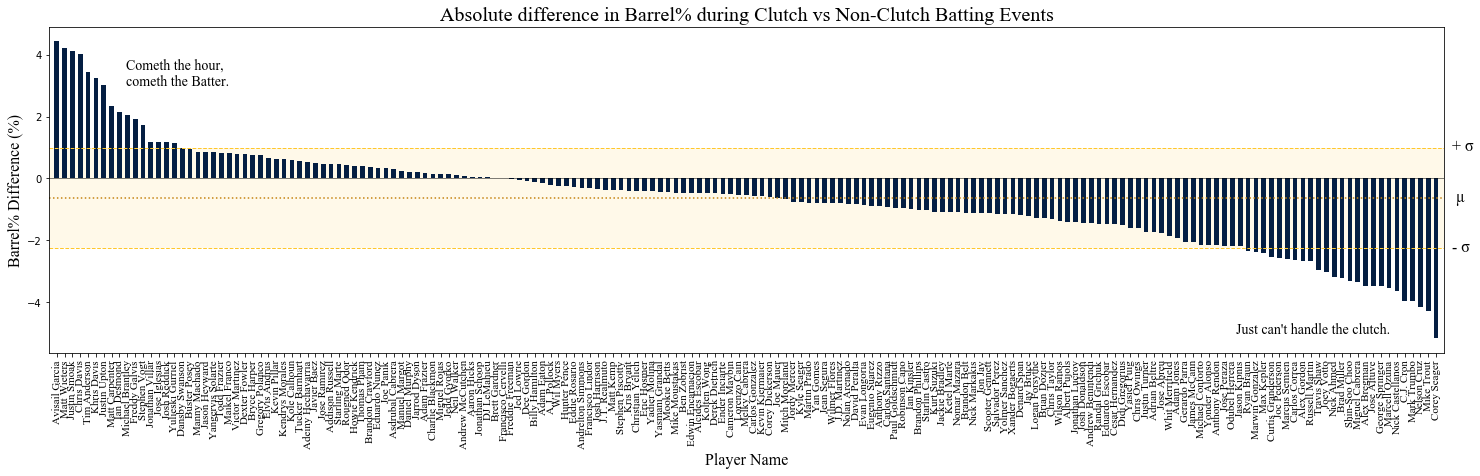

In [9]:
#Plot the data as a Barchart.
#Set ranges
y_up = bar_av + bar_std
y_low = bar_av - bar_std

fig, ax = plt.subplots(figsize = (25,6))
plt.xlim([-1,len(bar_comb)])

#Set up plot
ax.bar(x = bar_comb['Name'], height = bar_comb["bar%_delta"], width = 0.6, color = '#041E42')
ax.set_title("Absolute difference in Barrel% during Clutch vs Non-Clutch Batting Events",
            fontname = "Times New Roman",
             fontsize = 20)
ax.set_ylabel("Barrel% Difference (%)", fontname = "Times New Roman", fontsize = 16)
ax.set_xlabel("Player Name", fontname = "Times New Roman", fontsize = 16)
ax.set_xticklabels(bar_comb['Name'], rotation = 90, fontname = "Times New Roman", fontsize=11)
#ax.set_xticklabels([])

#Set the mean with stDev lines
ax.axhline(y=0, color='k', lw = 0.5)
ax.axhline(y_up, lw=1, color = '#FFC72C', linestyle = '--')
ax.axhline(bar_av, lw = 1.5, color = '#C4820F', linestyle = ':')
ax.axhline(y_low, lw=1, color = '#FFC72C', linestyle = '--')
ax.fill_between(range(-1,len(bar_comb)+1), y_low, y_up, facecolor='#FFC72C', alpha=0.1)

#Some labels
ax.text(len(bar_comb)/20,3,'Cometh the hour,\ncometh the Batter.', fontname = "Times New Roman", fontsize=14)
#ax.text(len(bar_comb)/3,0.45,'Within the plus side of 1 standard deviation.', fontname = "Times New Roman", fontsize=16)
#ax.text(len(bar_comb)/4,-1.5,'Within the minus side of 1 standard deviation.', fontname = "Times New Roman", fontsize=16)
ax.text(len(bar_comb)/20*17,-5,'Just can\'t handle the clutch.', fontname = "Times New Roman", fontsize=14)
ax.text(len(bar_comb)+1, y_up-0.1, '+ σ', fontname = "Times New Roman", fontsize=16)
ax.text(len(bar_comb)+1, bar_av-0.1, ' μ', fontname = "Times New Roman", fontsize=16)
ax.text(len(bar_comb)+1, y_low-0.1, '- σ', fontname = "Times New Roman", fontsize=16)

# Hide the right and top spines
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

plt.savefig('Barrelled.png', bbox_inches='tight')

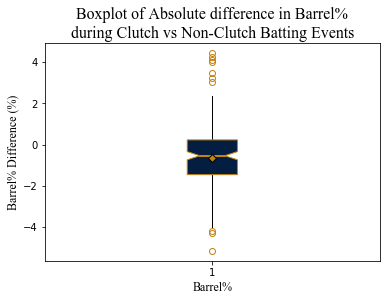

In [10]:
#Try Boxplot: 
fig, ax = plt.subplots()
ax.set_title("Boxplot of Absolute difference in Barrel%\nduring Clutch vs Non-Clutch Batting Events",
            fontname = "Times New Roman",
            fontsize = 16)
ax.set_ylabel("Barrel% Difference (%)", fontname = "Times New Roman", fontsize = 12)
ax.set_xlabel("Barrel%", fontname = "Times New Roman", fontsize = 12)
a1 = ax.boxplot(bar_comb["bar%_delta"], 
           notch=True,
           patch_artist=True,
           showcaps = False,
           showmeans = True,
           flierprops = dict(marker = 'o', markeredgecolor = '#C4820F'),
           meanprops = dict(markerfacecolor='#C4820F', marker='D', markeredgecolor ='k'),
           medianprops = dict(linewidth=2, color ='#C4820F'),
           boxprops = dict(color = '#C4820F', facecolor = '#041E42')
          )

plt.savefig('Barrelled_bp.png', bbox_inches='tight')

In [11]:
#Some stats:
#Percentage of players who don't improve in clutch events.
1- len(bar_comb[bar_comb['bar%_delta'] > 0]) / len(bar_comb) 
#The average:
bar_av
#The standard deviation
bar_std
#The median
bar_med

-0.5372956403269753

In [12]:
#Let's make a subset of the good and bad batters
new_comb = bar_comb[(bar_comb['bar%_delta'] > y_up) | (bar_comb['bar%_delta'] < y_low)]
#Let's import some batting statistics:
new_comb = new_comb.head(10).append(new_comb.tail(10), ignore_index=True)
new_df = new_comb[['Name','bar%_delta']]
new_df.columns = ['Batter','Barrel% Difference']

#Display formatting
#pd.options.display.float_format = '{:,.3}%'.format
#new_df.tail(10)
#new_df.head(10)

Hit distance

In [13]:
#let's look at hit_distance
#drop empty values:
clutch_df = clutch_df.dropna(how='any', subset=['hit_distance_sc'])
not_clutch_df = not_clutch_df.dropna(how='any', subset=['hit_distance_sc'])

clutch_by_batter = clutch_df.groupby("batter")
nclutch_by_batter = not_clutch_df.groupby("batter")

In [14]:
#Let's average the distance during clutch and non-clutch events. 

cb_batter = clutch_by_batter['hit_distance_sc'].agg([
    ('events','count'),
    ('c_av_dist', lambda x: x.mean())
]).sort_values(
    by = 'events',
    ascending = False
)

#Compare this to non-clutch situations
ncb_batter = nclutch_by_batter['hit_distance_sc'].agg([
    ('nc_events','count'),
    ('nc_av_dist', lambda x: x.mean())
]).sort_values(
    by = 'nc_events',
    ascending = False
)

#Let's filter only for players who have more faced a certain 
#amount of clutch and non-clutch situations:
min_events = 200
print("There are a total of {} players, we will filter to the experienced guys \
\nwho have recorded clutch batting events atleast {} times".format(len(cb_batter),min_events))
cb_batter = cb_batter[cb_batter['events'] > min_events]
ncb_batter = ncb_batter[ncb_batter['nc_events'] > min_events]
print("Now we have {} players".format(len(cb_batter)))

#Join the dataframes on the player index
dis_comb = pd.merge(cb_batter,
                    ncb_batter, 
                    left_index = True, 
                    right_index = True, 
                    how = 'left'
                   )

#Let's create some new columns which is the differences:
dis_comb['dist_delta'] = cb_batter['c_av_dist'] - ncb_batter['nc_av_dist']
dis_comb['dist_delta%'] = (cb_batter['c_av_dist'] - ncb_batter['nc_av_dist']) / ncb_batter['nc_av_dist'] * 100

#add in names
dis_comb = dis_comb.reset_index()
dis_comb = pd.merge(dis_comb, names, left_on = 'batter', right_on = 'MLBCODE', how = 'left')
#dis_comb

There are a total of 1234 players, we will filter to the experienced guys 
who have recorded clutch batting events atleast 200 times
Now we have 150 players


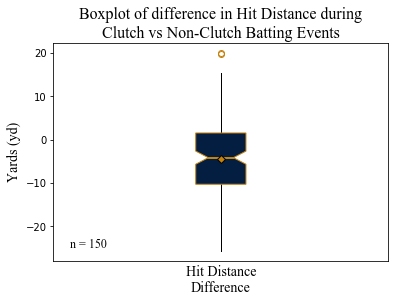

In [15]:
#Make Boxplot: 
fig, ax = plt.subplots()
ax.set_title("Boxplot of difference in Hit Distance during\nClutch vs Non-Clutch Batting Events",
            fontname = "Times New Roman",
            fontsize = 16)
ax.set_ylabel("Yards (yd)", fontname = "Times New Roman", fontsize = 14)
ax.set_xlabel("Hit Distance\nDifference", fontname = "Times New Roman", fontsize = 14)
ax.boxplot(dis_comb['dist_delta'], 
           notch=True,
           patch_artist=True,
           showcaps = False,
           showmeans = True,
           flierprops = dict(marker = 'o', markeredgecolor = '#C4820F'),
           meanprops = dict(markerfacecolor='#C4820F', marker='D', markeredgecolor ='k'),
           medianprops = dict(linewidth=2, color ='#C4820F'),
           boxprops = dict(color = '#C4820F', facecolor = '#041E42')
          )

ax.tick_params(bottom=False,labelbottom=False)
ax.text(0.55,-25,'n = {}'.format(len(cb_batter)), fontname = "Times New Roman", fontsize=12)


plt.savefig('hitdist_bp.png', bbox_inches='tight')

In [16]:
#Pull out Corey Seager and Avisail Garcia's Stats 
dis_comb[(dis_comb['Name']=='Corey Seager') | (dis_comb['Name']=='Avisail Garcia')][['Name','dist_delta']]

,Name,dist_delta
84,Avisail Garcia,1.439256
106,Corey Seager,-11.243617


In [17]:
#Some stats:
1- len(dis_comb[dis_comb['dist_delta'] > 0]) / len(dis_comb)

dis_av = dis_comb['dist_delta'].mean()
#dis_av
dis_std = dis_comb['dist_delta'].std()
#dis_std

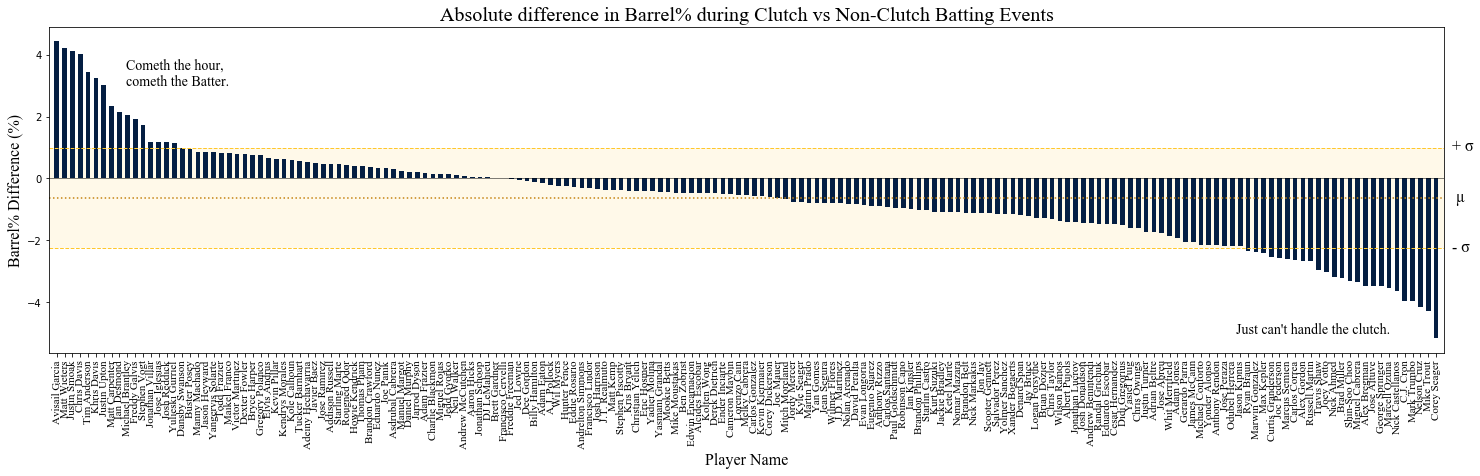

In [18]:
#Set ranges
y_up = bar_av + bar_std
y_low = bar_av - bar_std

#Bar chart with player names
fig, ax = plt.subplots(figsize = (25,6))
plt.xlim([-1,len(bar_comb)])

#Set up plot
ax.bar(x = bar_comb['Name'], height = bar_comb["bar%_delta"], width = 0.6, color = '#041E42')
ax.set_title("Absolute difference in Barrel% during Clutch vs Non-Clutch Batting Events",
            fontname = "Times New Roman",
             fontsize = 20)
ax.set_ylabel("Barrel% Difference (%)", fontname = "Times New Roman", fontsize = 16)
ax.set_xlabel("Player Name", fontname = "Times New Roman", fontsize = 16)
ax.set_xticklabels(bar_comb['Name'], rotation = 90, fontname = "Times New Roman", fontsize=11)
#ax.set_xticklabels([])

#Set the mean with stDev lines
ax.axhline(y=0, color='k', lw = 0.5)
ax.axhline(y_up, lw=1, color = '#FFC72C', linestyle = '--')
ax.axhline(bar_av, lw = 1.5, color = '#C4820F', linestyle = ':')
ax.axhline(y_low, lw=1, color = '#FFC72C', linestyle = '--')
ax.fill_between(range(-1,len(bar_comb)+1), y_low, y_up, facecolor='#FFC72C', alpha=0.1)

#Some labels
ax.text(len(bar_comb)/20,3,'Cometh the hour,\ncometh the Batter.', fontname = "Times New Roman", fontsize=14)
#ax.text(len(bar_comb)/3,0.45,'Within the plus side of 1 standard deviation.', fontname = "Times New Roman", fontsize=16)
#ax.text(len(bar_comb)/4,-1.5,'Within the minus side of 1 standard deviation.', fontname = "Times New Roman", fontsize=16)
ax.text(len(bar_comb)/20*17,-5,'Just can\'t handle the clutch.', fontname = "Times New Roman", fontsize=14)
ax.text(len(bar_comb)+1, y_up-0.1, '+ σ', fontname = "Times New Roman", fontsize=16)
ax.text(len(bar_comb)+1, bar_av-0.1, ' μ', fontname = "Times New Roman", fontsize=16)
ax.text(len(bar_comb)+1, y_low-0.1, '- σ', fontname = "Times New Roman", fontsize=16)

plt.savefig('Barrelled.png', bbox_inches='tight')

Hit Speed

In [19]:
#Hit speed#
#drop empty values:
clutch_df = clutch_df.dropna(how='any', subset=['launch_speed'])
not_clutch_df = not_clutch_df.dropna(how='any', subset=['launch_speed'])

clutch_by_batter = clutch_df.groupby("batter")
nclutch_by_batter = not_clutch_df.groupby("batter")

#OK let's now see how fast things were hit...
cb_batter = clutch_by_batter['launch_speed'].agg([
    ('events','count'),
    ('c_av_ls', lambda x: x.mean())
]).sort_values(
    by = 'events',
    ascending = False
)

#Compare this to non-clutch situations
ncb_batter = nclutch_by_batter['launch_speed'].agg([
    ('nc_events','count'),
    ('nc_av_ls', lambda x: x.mean())
]).sort_values(
    by = 'nc_events',
    ascending = False
)

#Let's filter only for players who have more faced a certain 
#amount of clutch and non-clutch situations:
min_events = 200
print("There are a total of {} players, we will filter to the experienced guys \
\nwho have recorded clutch batting events atleast {} times".format(len(cb_batter),min_events))
cb_batter = cb_batter[cb_batter['events'] > min_events]
ncb_batter = ncb_batter[ncb_batter['nc_events'] > min_events]
print("Now we have {} players".format(len(cb_batter)))

#Join the dataframes on the player index
ls_comb = pd.merge(cb_batter,
                    ncb_batter, 
                    left_index = True, 
                    right_index = True, 
                    how = 'left'
                   )

#Let's create some new columns which is the difference, absolute and percentage wise:
ls_comb['ls_delta'] = cb_batter['c_av_ls'] - ncb_batter['nc_av_ls']
ls_comb['ls_delta%'] = (cb_batter['c_av_ls'] - ncb_batter['nc_av_ls']) / ncb_batter['nc_av_ls'] * 100

#add in names
ls_comb = ls_comb.reset_index()
ls_comb = pd.merge(ls_comb, names, left_on = 'batter', right_on = 'MLBCODE', how = 'left')
#bar_comb
#cb_batter['c_av_ls']

#Sorting:
ls_comb = ls_comb[['ls_delta','ls_delta%','Name']].sort_values(by = 'ls_delta', ascending = False)

There are a total of 1234 players, we will filter to the experienced guys 
who have recorded clutch batting events atleast 200 times
Now we have 150 players


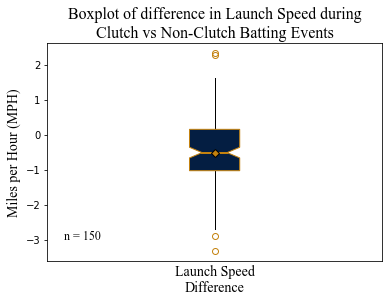

In [20]:
#Make Boxplot: 
fig, ax = plt.subplots()
ax.set_title("Boxplot of difference in Launch Speed during\nClutch vs Non-Clutch Batting Events",
            fontname = "Times New Roman",
            fontsize = 16)
ax.set_ylabel("Miles per Hour (MPH)", fontname = "Times New Roman", fontsize = 14)
ax.set_xlabel("Launch Speed\nDifference", fontname = "Times New Roman", fontsize = 14)
ax.boxplot(ls_comb['ls_delta'], 
           notch=True,
           patch_artist=True,
           showcaps = False,
           showmeans = True,
           flierprops = dict(marker = 'o', markeredgecolor = '#C4820F'),
           meanprops = dict(markerfacecolor='#C4820F', marker='D', markeredgecolor ='k'),
           medianprops = dict(linewidth=2, color ='#C4820F'),
           boxprops = dict(color = '#C4820F', facecolor = '#041E42')
          )

ax.tick_params(bottom=False,labelbottom=False)
ax.text(0.55,-3,'n = {}'.format(len(cb_batter)), fontname = "Times New Roman", fontsize=12)


plt.savefig('launchspd_bp.png', bbox_inches='tight')

In [21]:
#Some stats:
1- len(ls_comb[ls_comb['ls_delta'] > 0]) / len(ls_comb)

ls_av = ls_comb['ls_delta'].mean()
#dis_av
ls_std = ls_comb['ls_delta'].std()
#dis_std

In [22]:
#Pull out Corey Seager and Avisail Garcia's Stats 
ls_comb[(ls_comb['Name']=='Corey Seager') | (ls_comb['Name']=='Avisail Garcia')][['Name','ls_delta']]

,Name,ls_delta
84,Avisail Garcia,1.190427
106,Corey Seager,-1.138076


Expected batting Average 

In [23]:
#Batting Average
#drop empty values:
clutch_df = clutch_df.dropna(how='any', subset=['estimated_ba_using_speedangle'])
not_clutch_df = not_clutch_df.dropna(how='any', subset=['estimated_ba_using_speedangle'])

clutch_by_batter = clutch_df.groupby("batter")
nclutch_by_batter = not_clutch_df.groupby("batter")

#OK let's now see how fast things were hit...

cba_batter = clutch_by_batter['estimated_ba_using_speedangle'].agg([
    ('events','count'),
    ('c_av_ba', lambda x: x.mean())
]).sort_values(by = 'events', ascending = False)

#Compare this to non-clutch situations
ncba_batter = nclutch_by_batter['estimated_ba_using_speedangle'].agg([
    ('nc_events','count'),
    ('nc_av_ba', lambda x: x.mean())
]).sort_values(by = 'nc_events', ascending = False)

#Let's filter only for players who have more faced a certain 
#amount of clutch and non-clutch situations:
min_events = 200
print("There are a total of {} players, we will filter to the experienced guys \
\nwho have recorded clutch batting events atleast {} times".format(len(cba_batter),min_events))
cba_batter = cba_batter[cba_batter['events'] > min_events]
ncba_batter = ncba_batter[ncba_batter['nc_events'] > min_events]
print("Now we have {} players".format(len(cba_batter)))

#Join the dataframes on the player index
ba_comb = pd.merge(cba_batter,
                    ncba_batter, 
                    left_index = True, 
                    right_index = True, 
                    how = 'left'
                   )

#Let's create some new columns which is the differences:
ba_comb['ba_delta'] = cba_batter['c_av_ba'] - ncba_batter['nc_av_ba']
ba_comb['ba_delta%'] = (cba_batter['c_av_ba'] - ncba_batter['nc_av_ba']) / ncba_batter['nc_av_ba'] * 100

#add in names
ba_comb = ba_comb.reset_index()
ba_comb = pd.merge(ba_comb, names, left_on = 'batter', right_on = 'MLBCODE', how = 'left')
#bar_comb

There are a total of 1234 players, we will filter to the experienced guys 
who have recorded clutch batting events atleast 200 times
Now we have 150 players


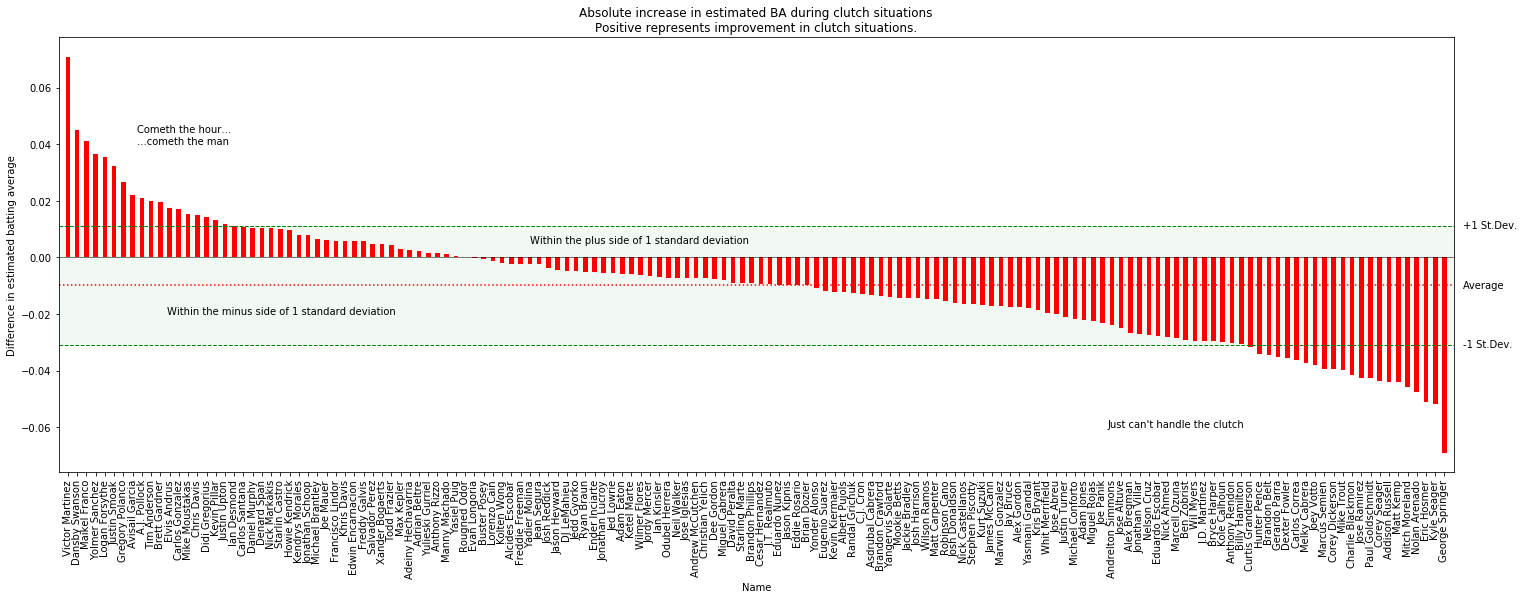

In [24]:
#Sorting:
ba_comb = ba_comb[['ba_delta','ba_delta%','Name']].sort_values(by = 'ba_delta', ascending = False)

#Some ranges:
ba_av = ba_comb['ba_delta'].mean()
ba_std = ba_comb['ba_delta'].std()
y_up = ba_av + ba_std
y_low = ba_av - ba_std

#plot that
fig, ax = plt.subplots(figsize = (25,8))
plt.xlim([-1,len(ls_comb)])

#Set up plot
ax.bar(x = ba_comb['Name'], height = ba_comb['ba_delta'], width = 0.5, color = 'red')
ax.set_title("Absolute increase in estimated BA during clutch situations\nPositive represents improvement in clutch situations.")
ax.set_ylabel("Difference in estimated batting average")
ax.set_xlabel("Name")
ax.set_xticklabels(ba_comb['Name'], rotation = 90)

#Set the mean with stDev lines
ax.axhline(y=0, color='k', lw = 0.5)
ax.axhline(y_up, lw=1, color = 'green', linestyle = '--')
ax.axhline(ba_av, lw = 1.5, color = 'red', linestyle = ':')
ax.axhline(y_low, lw=1, color = 'green', linestyle = '--')
ax.fill_between(range(-1,len(ls_comb)+1), y_low, y_up, facecolor='green', alpha=0.05)

#Some labels
ax.text(len(ba_comb)/20,0.04,'Cometh the hour...\n...cometh the man')
ax.text(len(ba_comb)/3,0.005,'Within the plus side of 1 standard deviation')
ax.text(len(ba_comb)/14,-0.02,'Within the minus side of 1 standard deviation')
ax.text(len(ba_comb)/20*15,-0.06,'Just can\'t handle the clutch')
ax.text(len(ba_comb)+1, y_up-0.001, '+1 St.Dev.')
ax.text(len(ba_comb)+1, ba_av-0.001, 'Average')
ax.text(len(ba_comb)+1, y_low-0.001, '-1 St.Dev.')

plt.savefig('xBA.png', bbox_inches='tight')

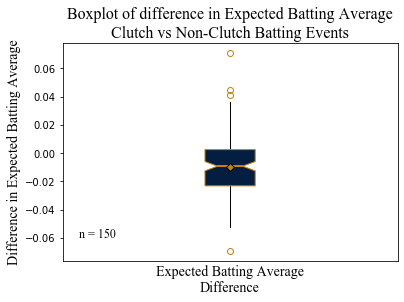

In [25]:
#Make Boxplot: 
fig, ax = plt.subplots()
ax.set_title("Boxplot of difference in Expected Batting Average\nClutch vs Non-Clutch Batting Events",
            fontname = "Times New Roman",
            fontsize = 16)
ax.set_ylabel("Difference in Expected Batting Average", fontname = "Times New Roman", fontsize = 14)
ax.set_xlabel("Expected Batting Average\nDifference", fontname = "Times New Roman", fontsize = 14)
ax.boxplot(ba_comb['ba_delta'], 
           notch=True,
           patch_artist=True,
           showcaps = False,
           showmeans = True,
           flierprops = dict(marker = 'o', markeredgecolor = '#C4820F'),
           meanprops = dict(markerfacecolor='#C4820F', marker='D', markeredgecolor ='k'),
           medianprops = dict(linewidth=2, color ='#C4820F'),
           boxprops = dict(color = '#C4820F', facecolor = '#041E42')
          )

ax.tick_params(bottom=False,labelbottom=False)
ax.text(0.55,-0.06,'n = {}'.format(len(cb_batter)), fontname = "Times New Roman", fontsize=12)


plt.savefig('xBA_bp.png', bbox_inches='tight')

In [26]:
ba_av
ba_std
1- len(ba_comb[ba_comb['ba_delta'] > 0]) / len(ba_comb)

0.7066666666666667

Contextual Information
Q1 - What is the typical barrel% we should expect season to season and how does this compare to the clutch effect on barrel %?

In [27]:
#Let's look at all regular season batting events and aggregate by player and season
fil_comb = stat_comb.dropna(how='any', subset=['launch_speed_angle'])

#Filter out players who have only played one season (we can't get an inter-season variance on players who
#have played only 1 season!)
criteria = fil_comb[['player_name','year']].groupby('player_name').agg({'year':lambda x: len(x.unique())>1})

#Get the list of names and use it to filter the original player name column
names_ls = criteria[criteria['year']==True].reset_index()['player_name']
fil_comb[fil_comb['player_name'].isin(names_ls)]

#Let's calculate the season barrel% for each player
res = fil_comb[
    ['player_name',
     'year',
     'launch_speed_angle']
].groupby(
    ['player_name',
     'year']
).agg([
    ('events','count'),
    ('bar%', lambda x: sum(x == 6)/x.count()*100)]
).reset_index()

#Rename columns
res.columns = ['name', 'year', 'events','barrelpct']
#Finally average the standard deviation of each players seasonal stdv
b_median = res.groupby('name').agg('std')['barrelpct'].median()
b_mean = res.groupby('name').agg('std')['barrelpct'].mean()

print("The median season-to-season standard deviation in barrel% for all players is {:.2f} \
and the mean is {:.2f}.".format(b_median,b_mean))

The median season-to-season standard deviation in barrel% for all players is 2.66 and the mean is 3.50.


In [28]:
#Let's compare Corey and Avisail 
#add in names
stat_comb = pd.merge(stat_comb, names, left_on = 'batter', right_on = 'MLBCODE', how = 'left')
Seager_Garcia = stat_comb[(stat_comb.Name == 'Corey Seager' )| (stat_comb.Name == 'Avisail Garcia' ) ]

comparison = Seager_Garcia.groupby(['Name','year']).agg({
    'launch_speed_angle':[lambda x: sum(x == 6)/x.count()*100],
    'estimated_ba_using_speedangle':'mean'
})

#Get some more player Data
#Let's import some batting statistics:
batting_data = pd.read_csv('../01_Data/batting_data_15_to_20.csv')
#for x in batting_data.columns:
#    print(x)
batt_data = batting_data[[
    'Name',
    'Season', 
    'AVG',
]]

Seager_Garcia2 = batt_data[(batt_data.Name == 'Corey Seager' )| (batt_data.Name == 'Avisail Garcia' ) ]
Seager_Garcia2 = Seager_Garcia2.reset_index()

#Rename columns
comparison.columns = ['Barrel%', 'xBA from Speed Angle']

#Reset the index and change the 'year' to integer to match the 
#The Seager_Garcia2 dataframe and enable merging. 
comparison = comparison.reset_index()
comparison['year'] = comparison['year'].astype(int)

#Let's join the two tables on name and year
combined_comparison = pd.merge(comparison,
                               Seager_Garcia2,
                               how = 'left',
                               left_on= ['Name','year'],
                               right_on = ['Name','Season']
                              )

combined_comparison[['Name',
                     'year',
                     'Barrel%',
                     'xBA from Speed Angle',
                     'AVG'
                    ]]

,Name,year,Barrel%,xBA from Speed Angle,AVG
0,Avisail Garcia,2015,4.962779,0.356005,0.257
1,Avisail Garcia,2016,8.108108,0.362932,NaN
2,Avisail Garcia,2017,8.845209,0.368115,0.330
3,Avisail Garcia,2018,11.583012,0.338880,NaN
4,Avisail Garcia,2019,11.716621,0.358627,0.282
5,Avisail Garcia,2020,3.787879,0.316705,0.238
6,Corey Seager,2015,10.256410,0.399821,NaN
7,Corey Seager,2016,8.350305,0.389589,0.308
8,Corey Seager,2017,8.536585,0.399256,0.295
9,Corey Seager,2018,8.333333,0.359548,NaN


In [29]:
#In summary
combined_comparison.groupby('Name').agg(['mean','std'])[[
    ('Barrel%','mean'),
    ('Barrel%','std'),
    ('xBA from Speed Angle','mean'),
    ('xBA from Speed Angle','std'),
    ('AVG','mean'),
    ('AVG','std')
]]

Barrel%           xBA from Speed Angle                AVG  \
                    mean       std                 mean       std     mean   
Name                                                                         
Avisail Garcia  8.167268  3.291690             0.350211  0.019172  0.27675   
Corey Seager    9.818393  3.215176             0.378316  0.030079  0.29550   

                          
                     std  
Name                      
Avisail Garcia  0.039811  
Corey Seager    0.016743